<a href="https://colab.research.google.com/github/kridtapon/Flow-Force-Strategy/blob/main/Flow_%26_Force_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# === Klinger Oscillator Calculation ===
def calculate_kvo(df, fast=34, slow=55, signal=13):
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']

    trend = close > close.shift(1)
    dm = high - low
    cm = np.where(trend, dm, -dm)
    vf = cm * volume

    vf = pd.Series(vf, index=df.index)
    kvo = vf.ewm(span=fast, min_periods=1).mean() - vf.ewm(span=slow, min_periods=1).mean()
    signal_line = kvo.ewm(span=signal, min_periods=1).mean()
    return kvo, signal_line

# === CCI Calculation ===
def calculate_cci(df, period=14):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(window=period).mean()
    mad = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=False)
    cci = (tp - sma) / (0.015 * mad)
    return cci

# === Download Data ===
symbol = 'VRSN'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Calculate Indicators ===
df['CCI'] = calculate_cci(df)
df['KVO'], df['KVO_Signal'] = calculate_kvo(df)

# === Strategy Logic ===
df['Entry'] = (
    (df['KVO'] > df['KVO_Signal']) &  # KVO crossover
    (df['CCI'] > -100) & (df['CCI'].shift(1) <= -100)  # CCI recovery
)

df['Exit'] = (
    (df['KVO'] < df['KVO_Signal']) &  # KVO crosses below signal
    ((df['CCI'] < 100) & (df['CCI'].shift(1) >= 100))  # CCI weakening
)

# === Filter Test Period ===
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Shift to Next Bar for Execution ===
shifted_entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Backtest Portfolio ===
portfolio = vbt.Portfolio.from_signals(
    close=df_test['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Output Stats and Plot ===
print(portfolio.stats())
portfolio.plot().show()


/tmp/ipython-input-15-2580778815.py:36: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           140086.765123
Total Return [%]                        40.086765
Benchmark Return [%]                     7.172541
Max Gross Exposure [%]                      100.0
Total Fees Paid                       4359.165276
Max Drawdown [%]                        29.520909
Max Drawdown Duration           544 days 00:00:00
Total Trades                                   15
Total Closed Trades                            15
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            66.666667
Best Trade [%]                          28.156271
Worst Trade [%]                        -12.720432
Avg Winning Trade [%]                     6.36907
Avg Losing Trade [%]                    -4.869086


In [16]:
# === Strategy Logic ===
df['Entry'] = (
    (df['KVO'] > df['KVO_Signal']) &  # KVO crossover
    (df['KVO'] < 0) & (df['KVO_Signal'] < 0) &
    (df['CCI'] > -100) & (df['CCI'].shift(1) <= -100) # CCI recovery
)

df['Exit'] = (
    (df['KVO'] < df['KVO_Signal']) &  # KVO crosses below signal
    (df['KVO'] > 0) & (df['KVO_Signal'] > 0) &
    ((df['CCI'] < 100) & (df['CCI'].shift(1) >= 100)) # CCI weakening
)

# === Filter Test Period ===
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Shift to Next Bar for Execution ===
shifted_entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Backtest Portfolio ===
portfolio = vbt.Portfolio.from_signals(
    close=df_test['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Output Stats and Plot ===
print(portfolio.stats())
portfolio.plot().show()

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           142870.743951
Total Return [%]                        42.870744
Benchmark Return [%]                     7.172541
Max Gross Exposure [%]                      100.0
Total Fees Paid                       2406.218858
Max Drawdown [%]                        25.938218
Max Drawdown Duration           417 days 00:00:00
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 75.0
Best Trade [%]                          28.156271
Worst Trade [%]                        -12.720432
Avg Winning Trade [%]                   10.655463
Avg Losing Trade [%]                   -10.944733


In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# === Klinger Oscillator Calculation ===
def calculate_kvo(df, fast=34, slow=55, signal=13):
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']

    trend = close > close.shift(1)
    dm = high - low
    cm = np.where(trend, dm, -dm)
    vf = cm * volume

    vf = pd.Series(vf, index=df.index)
    kvo = vf.ewm(span=fast, min_periods=1).mean() - vf.ewm(span=slow, min_periods=1).mean()
    signal_line = kvo.ewm(span=signal, min_periods=1).mean()
    return kvo, signal_line

# === CCI Calculation ===
def calculate_cci(df, period=14):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(window=period).mean()
    mad = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=False)
    cci = (tp - sma) / (0.015 * mad)
    return cci

# === Download Data ===
symbol = 'VRSN'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Calculate Indicators ===
df['CCI'] = calculate_cci(df)
df['KVO'], df['KVO_Signal'] = calculate_kvo(df)

# === Strategy Logic ===
df['Entry'] = (
    (df['KVO'] > df['KVO_Signal']) &  # KVO crossover
    (df['KVO'] < 0) & (df['KVO_Signal'] < 0) &
    (df['CCI'] > -100) & (df['CCI'].shift(1) <= -100) # CCI recovery
)

df['Exit'] = (
    (df['KVO'] < df['KVO_Signal']) &  # KVO crosses below signal
    (df['KVO'] > 0) & (df['KVO_Signal'] > 0) &
    ((df['CCI'] < 100) & (df['CCI'].shift(1) >= 100)) # CCI weakening
)

# === Filter Test Period ===
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Shift to Next Bar for Execution ===
shifted_entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

# === Backtest Portfolio ===
portfolio = vbt.Portfolio.from_signals(
    close=df_test['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Output Stats and Plot ===
print(portfolio.stats())
portfolio.plot().show()

/tmp/ipython-input-12-1848933952.py:36: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           142870.743951
Total Return [%]                        42.870744
Benchmark Return [%]                     7.172541
Max Gross Exposure [%]                      100.0
Total Fees Paid                       2406.218858
Max Drawdown [%]                        25.938218
Max Drawdown Duration           417 days 00:00:00
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 75.0
Best Trade [%]                          28.156271
Worst Trade [%]                        -12.720432
Avg Winning Trade [%]                   10.655463
Avg Losing Trade [%]                   -10.944733


/tmp/ipython-input-17-2478589554.py:35: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


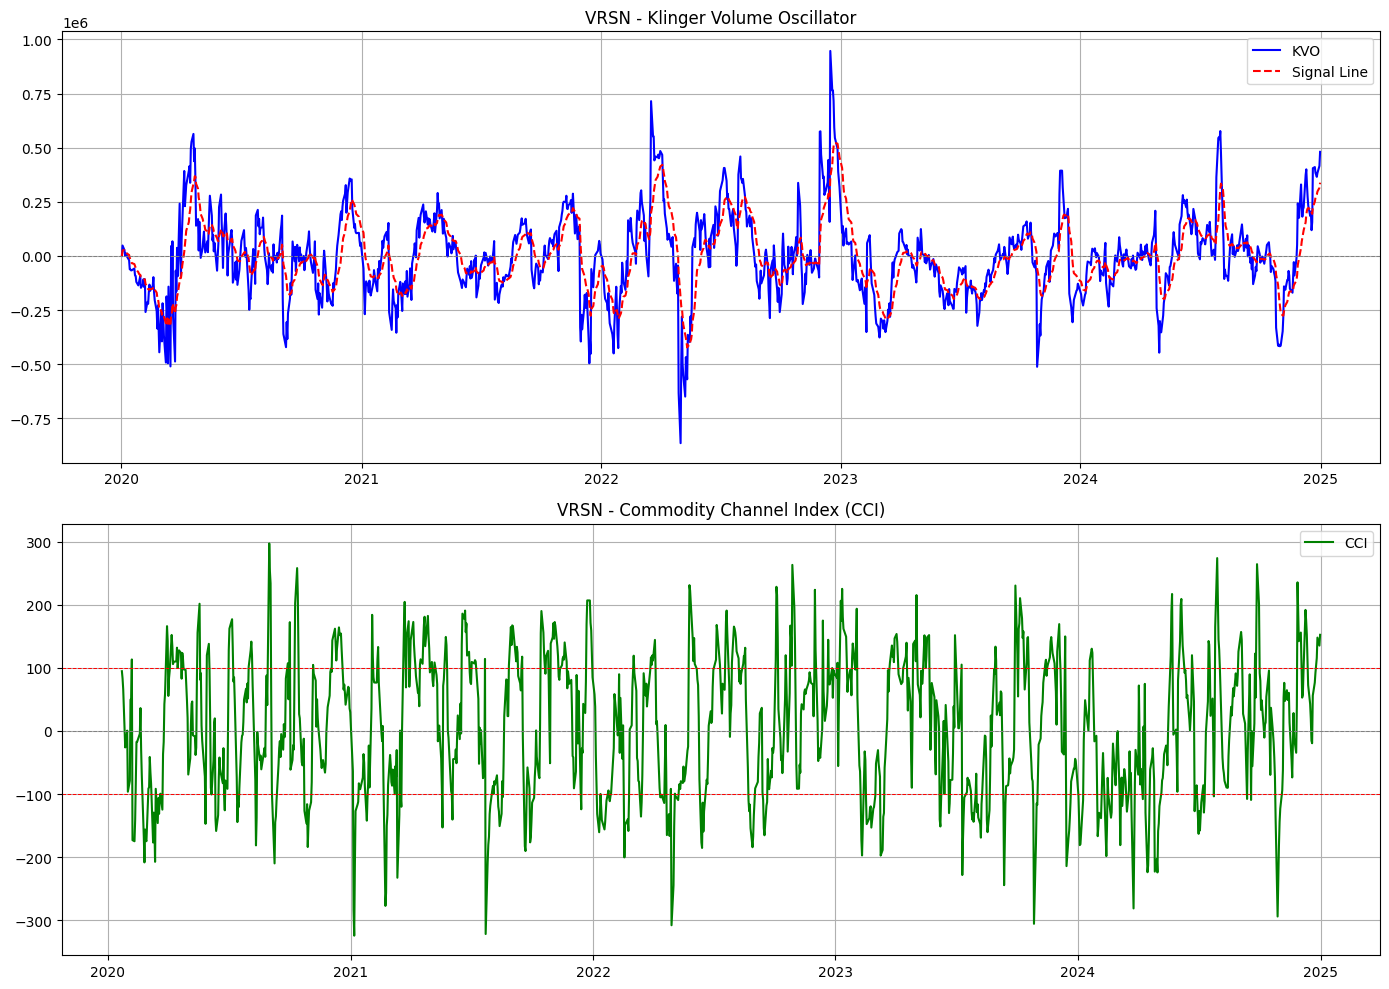

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Klinger Oscillator Calculation ===
def calculate_kvo(df, fast=34, slow=55, signal=13):
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']

    trend = close > close.shift(1)
    dm = high - low
    cm = np.where(trend, dm, -dm)
    vf = cm * volume

    vf = pd.Series(vf, index=df.index)
    kvo = vf.ewm(span=fast, min_periods=1).mean() - vf.ewm(span=slow, min_periods=1).mean()
    signal_line = kvo.ewm(span=signal, min_periods=1).mean()
    return kvo, signal_line

# === CCI Calculation ===
def calculate_cci(df, period=14):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(window=period).mean()
    mad = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=False)
    cci = (tp - sma) / (0.015 * mad)
    return cci

# === Download Data ===
symbol = 'VRSN'
start_date = '2020-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Calculate Indicators ===
df['KVO'], df['KVO_Signal'] = calculate_kvo(df)
df['CCI'] = calculate_cci(df)

# === Plot ===
plt.figure(figsize=(14, 10))

# --- KVO Plot ---
plt.subplot(2, 1, 1)
plt.plot(df.index, df['KVO'], label='KVO', color='blue')
plt.plot(df.index, df['KVO_Signal'], label='Signal Line', color='red', linestyle='--')
plt.title(f'{symbol} - Klinger Volume Oscillator')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.legend()
plt.grid(True)

# --- CCI Plot ---
plt.subplot(2, 1, 2)
plt.plot(df.index, df['CCI'], label='CCI', color='green')
plt.axhline(100, color='red', linestyle='--', linewidth=0.7)
plt.axhline(-100, color='red', linestyle='--', linewidth=0.7)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title(f'{symbol} - Commodity Channel Index (CCI)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/tmp/ipython-input-18-2997088405.py:35: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


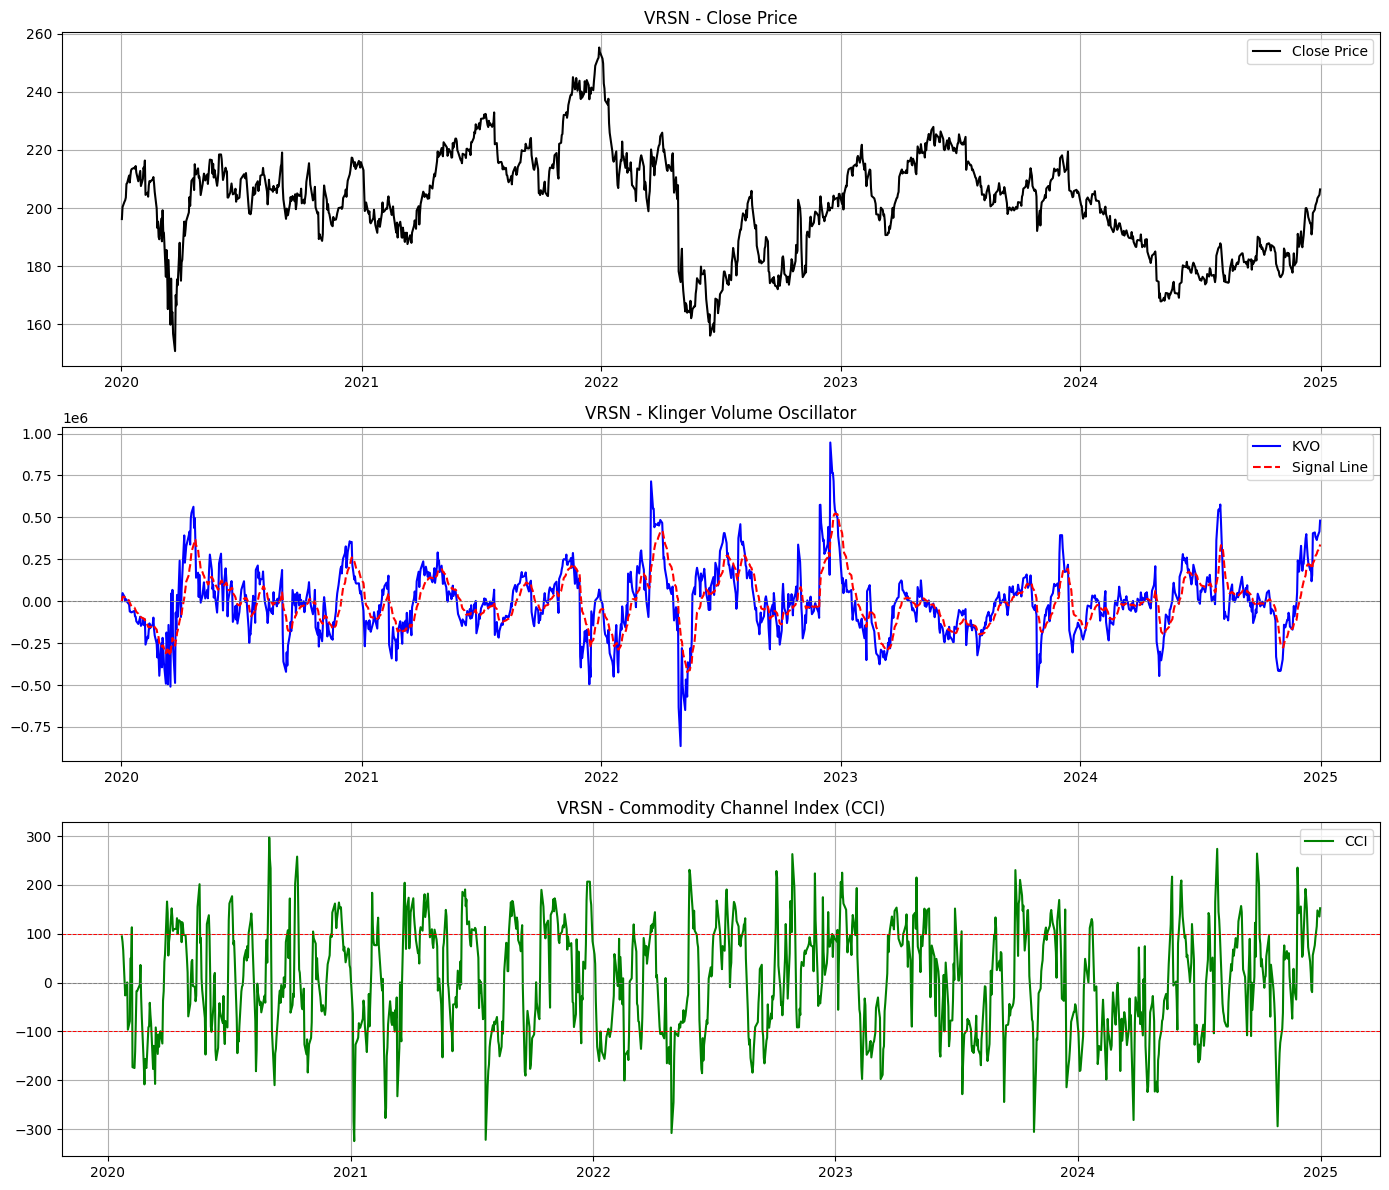

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Klinger Oscillator Calculation ===
def calculate_kvo(df, fast=34, slow=55, signal=13):
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']

    trend = close > close.shift(1)
    dm = high - low
    cm = np.where(trend, dm, -dm)
    vf = cm * volume

    vf = pd.Series(vf, index=df.index)
    kvo = vf.ewm(span=fast, min_periods=1).mean() - vf.ewm(span=slow, min_periods=1).mean()
    signal_line = kvo.ewm(span=signal, min_periods=1).mean()
    return kvo, signal_line

# === CCI Calculation ===
def calculate_cci(df, period=14):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(window=period).mean()
    mad = tp.rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=False)
    cci = (tp - sma) / (0.015 * mad)
    return cci

# === Download Data ===
symbol = 'VRSN'
start_date = '2020-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === Calculate Indicators ===
df['KVO'], df['KVO_Signal'] = calculate_kvo(df)
df['CCI'] = calculate_cci(df)

# === Plot ===
plt.figure(figsize=(14, 12))

# --- Close Price Plot ---
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', color='black')
plt.title(f'{symbol} - Close Price')
plt.legend()
plt.grid(True)

# --- KVO Plot ---
plt.subplot(3, 1, 2)
plt.plot(df.index, df['KVO'], label='KVO', color='blue')
plt.plot(df.index, df['KVO_Signal'], label='Signal Line', color='red', linestyle='--')
plt.title(f'{symbol} - Klinger Volume Oscillator')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.legend()
plt.grid(True)

# --- CCI Plot ---
plt.subplot(3, 1, 3)
plt.plot(df.index, df['CCI'], label='CCI', color='green')
plt.axhline(100, color='red', linestyle='--', linewidth=0.7)
plt.axhline(-100, color='red', linestyle='--', linewidth=0.7)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title(f'{symbol} - Commodity Channel Index (CCI)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
